# A gratuitously complex adding machine

Goal: Buil a FFN that can add two integers between -10 and 10

Input: Two integers
Output: SUm



In [293]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Create Data

In [294]:
N = 2000

sum1 = np.random.randint(-10,11,N)
sum1 = sum1.astype(float)
sum2 = np.random.randint(-10,11,N)
sum2 = sum2.astype(float)

totsum = sum1 + sum2

data = pd.DataFrame()
data['sum1'] = sum1
data['sum2'] = sum2
data['Total Sum'] = totsum

data

,sum1,sum2,Total Sum
0,9.0,5.0,14.0
1,-8.0,-10.0,-18.0
2,-1.0,-3.0,-4.0
3,6.0,1.0,7.0
4,4.0,6.0,10.0
...,...,...,...
1995,3.0,8.0,11.0
1996,0.0,2.0,2.0
1997,-6.0,2.0,-4.0
1998,-5.0,-6.0,-11.0


# Process Data

In [295]:
cols2zscore = data.keys()
print(cols2zscore)
cols2zscore = cols2zscore.drop('Total Sum')
print(cols2zscore)

data[cols2zscore].values

Index(['sum1', 'sum2', 'Total Sum'], dtype='object')
Index(['sum1', 'sum2'], dtype='object')


array([[  9.,   5.],
       [ -8., -10.],
       [ -1.,  -3.],
       ...,
       [ -6.,   2.],
       [ -5.,  -6.],
       [  2.,   9.]])

In [296]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['Total Sum'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 8
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])



# The DL parts: class for the model, and a function to train it

In [297]:
# create a class for the model
def createAddingMachine(nUnits,nLayers):

  class addingMachine(nn.Module):
    def __init__(self,nUnits,nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(2,nUnits)
      
      ### hidden layers
      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
      

      ### output layer
      self.layers['output'] = nn.Linear(nUnits,1)
    

    # forward pass
    def forward(self,x):
      # input layer
      x = self.layers['input'](x)

      # hidden layers
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )
      
      # return output layer
      x = self.layers['output'](x)
      return x
  
  # create the model instance
  net = addingMachine(nUnits,nLayers)
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [298]:
### a function that trains the model

# global parameter
numepochs = 25

def trainTheModel(nUnits, nLayers):

  # loss function and optimizer
  net,lossfun,optimizer = createAddingMachine(nUnits,nLayers)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)

      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean((torch.abs(yHat-y)<1).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    
    testAcc.append( 100*torch.mean((torch.abs(yHat-y)<1).float()).item() )
    
  
  # function output
  return trainAcc,testAcc,losses,net

In [299]:

# Test the model with fake input

nUnits = 30
nLayers = 1

net,lossf,opt = createAddingMachine(nUnits,nLayers)

input = torch.rand(10,2)
print(net)
net(input)

addingMachine(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=30, bias=True)
    (hidden0): Linear(in_features=30, out_features=30, bias=True)
    (output): Linear(in_features=30, out_features=1, bias=True)
  )
)


tensor([[ 0.1207],
        [-0.0070],
        [ 0.0612],
        [-0.0171],
        [-0.0140],
        [-0.0186],
        [ 0.0799],
        [ 0.0413],
        [-0.0002],
        [ 0.0159]], grad_fn=<AddmmBackward0>)

In [300]:
net,lossf,opt = createAddingMachine(nUnits,nLayers)
trainAcc,testAcc,losses,net = trainTheModel(nUnits,nLayers)


In [301]:
max(trainAcc)

100.0

In [302]:
# run teh model 10 times to check reproducability

for i in range(10):
  net,lossf,opt = createAddingMachine(nUnits,nLayers)
  trainAcc,testAcc,losses,net = trainTheModel(nUnits,nLayers)
  print(f'Model instance {i+1}, final TRAIN/TEST accuracies: {trainAcc[-1]:.2f}, {trainAcc[-1]:.2f}')

Model instance 1, final TRAIN/TEST accuracies: 96.56, 96.56
Model instance 2, final TRAIN/TEST accuracies: 100.00, 100.00
Model instance 3, final TRAIN/TEST accuracies: 100.00, 100.00
Model instance 4, final TRAIN/TEST accuracies: 100.00, 100.00
Model instance 5, final TRAIN/TEST accuracies: 100.00, 100.00
Model instance 6, final TRAIN/TEST accuracies: 98.89, 98.89
Model instance 7, final TRAIN/TEST accuracies: 99.83, 99.83
Model instance 8, final TRAIN/TEST accuracies: 100.00, 100.00
Model instance 9, final TRAIN/TEST accuracies: 100.00, 100.00
Model instance 10, final TRAIN/TEST accuracies: 100.00, 100.00


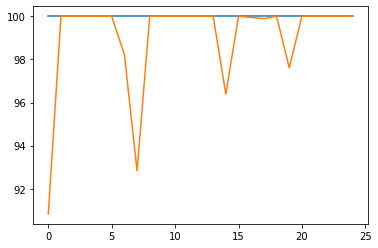

In [303]:
plt.plot(testAcc)
plt.plot(trainAcc)

tensor([[ -1., -10.],
        [  3.,   4.],
        [  5.,   7.],
        [  6.,   7.],
        [ -7.,  10.],
        [ 10.,  -6.],
        [  4.,  -3.],
        [  4.,   4.],
        [  6.,   7.],
        [  5.,   9.],
        [ -9.,   9.],
        [ -8.,   4.],
        [ -5.,  -9.],
        [  1., -10.],
        [-10.,  -4.],
        [  9.,   4.],
        [ -1.,   7.],
        [  8.,  -3.],
        [ -2.,  -7.],
        [  5.,  10.],
        [  3., -10.],
        [  4.,  -7.],
        [ -7.,   6.],
        [-10., -10.],
        [ 10.,  -8.],
        [ -6.,   8.],
        [ -4.,  -4.],
        [ -7.,  -7.],
        [ -2.,  -9.],
        [ 10.,  -2.],
        [ -1.,  10.],
        [ -7.,   4.],
        [ -9.,   6.],
        [  7.,  -5.],
        [  7.,   2.],
        [  2.,  -3.],
        [  7., -10.],
        [ -9.,   0.],
        [  7.,  -8.],
        [  1.,   7.],
        [  1.,  -6.],
        [ -7.,  -6.],
        [  6.,   2.],
        [ -4.,  10.],
        [  6.,   1.],
        [ 

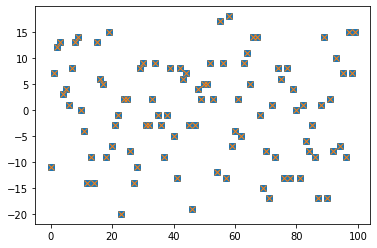

In [304]:
dataplot = torch.randint(low = -10, high = 11,size = (100,2)).float()
print(dataplot)

lables = torch.sum(dataplot,axis = 1,keepdim = True)

with torch.no_grad():
  predictions = net(dataplot)

plt.plot(lables,'s')
plt.plot(np.round(predictions.detach()),'x')


In [305]:

net(torch.tensor( data[cols2zscore].values ).float())

tensor([[ 13.8545],
        [-17.9760],
        [ -4.0077],
        ...,
        [ -4.0703],
        [-10.9966],
        [ 10.9105]], grad_fn=<AddmmBackward0>)